# Modelos predictivos con **Student Academic Stress** (replicando el notebook de IBM SLR/MLR)

**Objetivo**  
Crear un flujo de trabajo similar al del notebook de IBM (SLR/MLR, polinomios, `Pipeline`, métricas) usando el dataset de Kaggle **Student Academic Stress Real-World Dataset**. Incluyo dos rutas:

- **Ruta A (Regresión):** si tu variable objetivo es **numérica** (p.ej., GPA).  
- **Ruta B (Clasificación):** si tu variable objetivo es **categórica/ordinal** (p.ej., *stress_level* = {Low, Moderate, High}).

> Puedes ejecutar solo la ruta que aplique a tu caso.


## 0. Requisitos del entorno (ejecuta una vez)


In [2]:

# Si te hace falta, instala/actualiza paquetes (ejecuta si es necesario).
# Quita el "!" si trabajas en algunos entornos corporativos restringidos.
# Puedes comentar las líneas que no necesites.
# Actualizar pip
!python -m pip install --upgrade pip

# Instalar librerías necesarias
!python -m pip install kaggle pandas numpy scikit-learn matplotlib seaborn




## 1. Descargar el dataset de Kaggle (opción A: Kaggle CLI)

1. Ve a: https://www.kaggle.com/account → **Create New Token**.  
2. Guarda `kaggle.json` en:
   - **Windows:** `C:\Users\TU_USUARIO\.kaggle\kaggle.json`
   - **macOS/Linux:** `~/.kaggle/kaggle.json`
3. (Windows) Si falla por permisos, intenta marcar el archivo como solo lectura desde Propiedades.

Luego ejecuta:


In [3]:
import kagglehub

# Descarga usando el identificador del dataset (no la ruta local)
path = kagglehub.dataset_download("mdsultanulislamovi/student-stress-monitoring-datasets")

print("Ruta local al dataset:", path)


C:\Users\RaulCamara\anaconda3\envs\jupyter_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Ruta local al dataset: C:\Users\RaulCamara\.cache\kagglehub\datasets\mdsultanulislamovi\student-stress-monitoring-datasets\versions\1



## 1b. Descargar manualmente (opción B)
Descarga el/los `.csv` desde la página del dataset y colócalos dentro de la carpeta `data_stress/`.



## 2. Cargar el/los CSV y explorar estructura
La siguiente celda intenta **detectar automáticamente** archivos `.csv` en `data_stress/` para evitar depender del nombre exacto.


In [4]:

import pandas as pd
from pathlib import Path
import glob

DATA_DIR = Path("data_stress")

# Busca CSVs en la carpeta
csv_files = sorted(glob.glob(str(DATA_DIR / "**" / "*.csv"), recursive=True))
print("Archivos CSV encontrados:", csv_files)

assert len(csv_files) > 0, "No se encontraron CSVs en data_stress/. Coloca el archivo y vuelve a ejecutar."

# Si hay más de uno, elige el primero por defecto o cambia el índice manualmente
CSV_PATH = csv_files[0]
print("Usando:", CSV_PATH)

df = pd.read_csv(CSV_PATH)
print("Forma (rows, cols):", df.shape)
df.head()


Archivos CSV encontrados: ['data_stress\\StressLevelDataset.csv', 'data_stress\\Stress_Dataset.csv']
Usando: data_stress\StressLevelDataset.csv
Forma (rows, cols): (1100, 21)


,anxiety_level,self_esteem,mental_health_history,depression,headache,blood_pressure,sleep_quality,breathing_problem,noise_level,living_conditions,...,basic_needs,academic_performance,study_load,teacher_student_relationship,future_career_concerns,social_support,peer_pressure,extracurricular_activities,bullying,stress_level
0,14,20,0,11,2,1,2,4,2,3,...,2,3,2,3,3,2,3,3,2,1
1,15,8,1,15,5,3,1,4,3,1,...,2,1,4,1,5,1,4,5,5,2
2,12,18,1,14,2,1,2,2,2,2,...,2,2,3,3,2,2,3,2,2,1
3,16,12,1,15,4,3,1,3,4,2,...,2,2,4,1,4,1,4,4,5,2
4,16,28,0,7,2,3,5,1,3,2,...,3,4,3,1,2,1,5,0,5,1



## 3. Limpieza básica y normalización de nombres de columnas
- Quita espacios, convierte a `snake_case` y homogeniza valores simples (por ejemplo, "Yes/No").
- Ajusta mapeos según necesites.


In [5]:

import numpy as np

# Normaliza nombres de columnas
df.columns = (
    df.columns.str.strip()
             .str.replace(r"\s+", "_", regex=True)
             .str.replace(r"[^0-9a-zA-Z_]", "", regex=True)
             .str.lower()
)

# Ejemplos de mapeos rápidos (ajusta a tu csv real)
yes_no_maps = {"yes": 1, "no": 0, "y": 1, "n": 0}
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].astype(str).str.strip().str.lower()
        # Mapea yes/no si aplica
        if set(df[col].unique()) <= set(yes_no_maps.keys() | {"nan"}):
            df[col] = df[col].map(yes_no_maps)

print("Tipos:", df.dtypes)
df.head(11)


Tipos: anxiety_level                   int64
self_esteem                     int64
mental_health_history           int64
depression                      int64
headache                        int64
blood_pressure                  int64
sleep_quality                   int64
breathing_problem               int64
noise_level                     int64
living_conditions               int64
safety                          int64
basic_needs                     int64
academic_performance            int64
study_load                      int64
teacher_student_relationship    int64
future_career_concerns          int64
social_support                  int64
peer_pressure                   int64
extracurricular_activities      int64
bullying                        int64
stress_level                    int64
dtype: object


,anxiety_level,self_esteem,mental_health_history,depression,headache,blood_pressure,sleep_quality,breathing_problem,noise_level,living_conditions,...,basic_needs,academic_performance,study_load,teacher_student_relationship,future_career_concerns,social_support,peer_pressure,extracurricular_activities,bullying,stress_level
0,14,20,0,11,2,1,2,4,2,3,...,2,3,2,3,3,2,3,3,2,1
1,15,8,1,15,5,3,1,4,3,1,...,2,1,4,1,5,1,4,5,5,2
2,12,18,1,14,2,1,2,2,2,2,...,2,2,3,3,2,2,3,2,2,1
3,16,12,1,15,4,3,1,3,4,2,...,2,2,4,1,4,1,4,4,5,2
4,16,28,0,7,2,3,5,1,3,2,...,3,4,3,1,2,1,5,0,5,1
5,20,13,1,21,3,3,1,4,3,2,...,1,2,5,2,5,1,4,4,5,2
6,4,26,0,6,1,2,4,1,1,4,...,4,5,1,4,1,3,2,2,1,0
7,17,3,1,22,4,3,1,5,3,1,...,1,1,3,2,4,1,4,4,5,2
8,13,22,1,12,3,1,2,4,3,3,...,3,3,3,2,3,3,3,2,2,1
9,6,8,0,27,4,3,1,2,0,5,...,2,2,2,1,5,1,5,3,4,1



## 4. Inspección rápida (info, nulos, descripciones)


In [6]:

display(df.info())
print("\nNulos por columna:\n", df.isna().sum())
display(df.describe(include="all").T.head(20))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   anxiety_level                 1100 non-null   int64
 1   self_esteem                   1100 non-null   int64
 2   mental_health_history         1100 non-null   int64
 3   depression                    1100 non-null   int64
 4   headache                      1100 non-null   int64
 5   blood_pressure                1100 non-null   int64
 6   sleep_quality                 1100 non-null   int64
 7   breathing_problem             1100 non-null   int64
 8   noise_level                   1100 non-null   int64
 9   living_conditions             1100 non-null   int64
 10  safety                        1100 non-null   int64
 11  basic_needs                   1100 non-null   int64
 12  academic_performance          1100 non-null   int64
 13  study_load                    110

None


Nulos por columna:
 anxiety_level                   0
self_esteem                     0
mental_health_history           0
depression                      0
headache                        0
blood_pressure                  0
sleep_quality                   0
breathing_problem               0
noise_level                     0
living_conditions               0
safety                          0
basic_needs                     0
academic_performance            0
study_load                      0
teacher_student_relationship    0
future_career_concerns          0
social_support                  0
peer_pressure                   0
extracurricular_activities      0
bullying                        0
stress_level                    0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
anxiety_level,1100.0,11.063636,6.117558,0.0,6.0,11.0,16.0,21.0
self_esteem,1100.0,17.777273,8.944599,0.0,11.0,19.0,26.0,30.0
mental_health_history,1100.0,0.492727,0.500175,0.0,0.0,0.0,1.0,1.0
depression,1100.0,12.555455,7.727008,0.0,6.0,12.0,19.0,27.0
headache,1100.0,2.508182,1.409356,0.0,1.0,3.0,3.0,5.0
blood_pressure,1100.0,2.181818,0.833575,1.0,1.0,2.0,3.0,3.0
sleep_quality,1100.0,2.660000,1.548383,0.0,1.0,2.5,4.0,5.0
breathing_problem,1100.0,2.753636,1.400713,0.0,2.0,3.0,4.0,5.0
noise_level,1100.0,2.649091,1.328127,0.0,2.0,3.0,3.0,5.0
living_conditions,1100.0,2.518182,1.119208,0.0,2.0,2.0,3.0,5.0


### Mostrar mínimos y máximos



In [7]:
df.agg(['min', 'max']).T

,min,max
anxiety_level,0,21
self_esteem,0,30
mental_health_history,0,1
depression,0,27
headache,0,5
blood_pressure,1,3
sleep_quality,0,5
breathing_problem,0,5
noise_level,0,5
living_conditions,0,5



## 5. Define **objetivo** y elige ruta (Regresión vs Clasificación)

- Si tu **objetivo es numérico** (e.g., `gpa`, `score`), usa **Ruta A**.  
- Si tu **objetivo es categórico** (e.g., `stress_level` con valores como *low/moderate/high*), usa **Ruta B**.

Debes ajustar `TARGET_COL` abajo al nombre que corresponda en tu CSV.


In [8]:

# ⬇️ Cambia esto según tu dataset
TARGET_COL = "anxiety_level"  # cambia según tu dataset

assert TARGET_COL in df.columns, f"{TARGET_COL} no está en df.columns. Ajusta el nombre."
df[TARGET_COL].head(10)



0    14
1    15
2    12
3    16
4    16
5    20
6     4
7    17
8    13
9     6
Name: anxiety_level, dtype: int64


---
# Ruta A — **Regresión** (replicando SLR/MLR del notebook de IBM)

> Usa esta ruta si `df[TARGET_COL]` es **numérica**. Si no lo es, salta a **Ruta B**.


In [9]:

# Comprueba tipo objetivo; si no es numérico, no ejecutes esta ruta.
is_numeric_target = pd.api.types.is_numeric_dtype(df[TARGET_COL])
print("Objetivo numérico:", is_numeric_target)


Objetivo numérico: True



## 5A.1 División de columnas (numéricas/categóricas) y relleno de nulos


In [10]:

# Separa numéricas y categóricas
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols]

print("Numéricas:", num_cols[:10], "...")
print("Categóricas:", cat_cols[:10], "...")

# Rellena nulos (simple)
df_num = df[num_cols].copy()
df_num = df_num.fillna(df_num.median(numeric_only=True))

# (Opcional) one-hot a categóricas para usarlas después en MLR
df_cat = df[cat_cols].copy()
df_cat = pd.get_dummies(df_cat, drop_first=True, dtype=int)

df_ml = pd.concat([df_num, df_cat], axis=1)
print("df_ml shape:", df_ml.shape)


Numéricas: ['anxiety_level', 'self_esteem', 'mental_health_history', 'depression', 'headache', 'blood_pressure', 'sleep_quality', 'breathing_problem', 'noise_level', 'living_conditions'] ...
Categóricas: [] ...


ValueError: No objects to concatenate


## 5A.2 **SLR** — Regresión lineal simple (como en IBM: slope, intercept, fórmula y predicción)
- Elegimos automáticamente la variable numérica con mayor correlación absoluta con el objetivo.
- Imprimimos `intercept_` y `coef_` y reconstruimos la fórmula **y = b0 + b1·x**.


Top correlaciones con el objetivo:


stress_level                    0.736795
future_career_concerns          0.717016
sleep_quality                   0.710292
bullying                        0.709982
depression                      0.694340
self_esteem                     0.672745
teacher_student_relationship    0.663176
safety                          0.651220
academic_performance            0.649601
peer_pressure                   0.642910
Name: anxiety_level, dtype: float64

Usando como X (SLR): stress_level
Intercepto (b0): 5.5980 | Pendiente (b1): 5.4856
Fórmula: y_hat = 5.5980 + 5.4856 · stress_level
MSE: 17.092411042786257
R^2: 0.5428674949047606


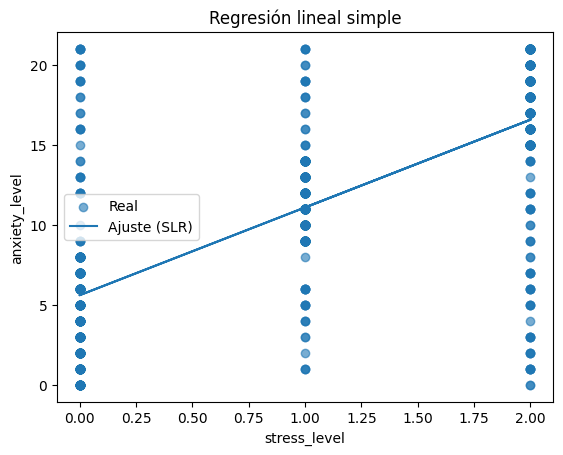

In [11]:

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

assert is_numeric_target, "El objetivo no es numérico; usa la Ruta B (clasificación)."

# Correlación simple con el objetivo
corrs = df_num.corr(numeric_only=True)[TARGET_COL].drop(labels=[TARGET_COL], errors="ignore").abs().sort_values(ascending=False)
print("Top correlaciones con el objetivo:")
display(corrs.head(10))

top_feature = corrs.index[0]
print("Usando como X (SLR):", top_feature)

X = df[[top_feature]]
y = df[TARGET_COL]

lm = LinearRegression()
lm.fit(X, y)

b0 = lm.intercept_
b1 = lm.coef_[0]
print(f"Intercepto (b0): {b0:.4f} | Pendiente (b1): {b1:.4f}")
print(f"Fórmula: y_hat = {b0:.4f} + {b1:.4f} · {top_feature}")

y_hat = lm.predict(X)

from sklearn.metrics import mean_squared_error, r2_score
print("MSE:", mean_squared_error(y, y_hat))
print("R^2:", r2_score(y, y_hat))

# Gráfico simple Actual vs Predicho
plt.figure()
plt.scatter(X, y, alpha=0.6, label="Real")
plt.plot(X, y_hat, label="Ajuste (SLR)")
plt.xlabel(top_feature); plt.ylabel(TARGET_COL)
plt.title("Regresión lineal simple")
plt.legend(); plt.show()



## 5A.3 **MLR** — Regresión lineal múltiple + `Pipeline` con `PolynomialFeatures` (como en IBM)
- Seleccionamos **k** mejores predictores numéricos por correlación (puedes ajustar `TOP_K`).  
- Armamos un `Pipeline` con `StandardScaler` + `PolynomialFeatures` + `LinearRegression`.


In [12]:

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score

TOP_K = min(5, len(corrs))  # ajusta si quieres
best_features = corrs.index[:TOP_K].tolist()
print("Features MLR:", best_features)

Z = df[best_features].copy()

X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size=0.2, random_state=42)

pipe = Pipeline([
    ("scale", StandardScaler(with_mean=True, with_std=True)),
    ("poly", PolynomialFeatures(degree=3, include_bias=False)),
    ("linreg", LinearRegression())
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print("MSE (test):", mean_squared_error(y_test, y_pred))
print("R^2  (test):", r2_score(y_test, y_pred))

# CV opcional
cv_scores = cross_val_score(pipe, Z, y, cv=5, scoring="r2")
print("CV R^2 (media±std):", f"{cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Features MLR: ['stress_level', 'future_career_concerns', 'sleep_quality', 'bullying', 'depression']
MSE (test): 18.3745651273899
R^2  (test): 0.5096993169392345
CV R^2 (media±std): 0.5660 ± 0.0217



---
# Ruta B — **Clasificación** (si el objetivo es categórico/ordinal)

Si `df[TARGET_COL]` no es numérico, mapeamos categorías a enteros (ejemplo: *low/moderate/high* → 0/1/2) y probamos un modelo base (Logistic Regression).


In [13]:

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

if not pd.api.types.is_numeric_dtype(df[TARGET_COL]):
    le = LabelEncoder()
    y_cls = le.fit_transform(df[TARGET_COL].astype(str))
else:
    y_cls = df[TARGET_COL].astype(int)

# Prepara X con numéricas + dummies de categóricas
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols + [TARGET_COL]]

X_cls = pd.concat([df[num_cols], pd.get_dummies(df[cat_cols], drop_first=True, dtype=int)], axis=1)
X_cls = X_cls.fillna(X_cls.median(numeric_only=True))

X_train, X_test, y_train, y_test = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))
print("\nMatriz de confusión:\n", confusion_matrix(y_test, y_pred))

# Importancias aproximadas (coeficientes absolutos en LR)
import numpy as np
if hasattr(clf, "coef_"):
    importances = np.abs(clf.coef_).mean(axis=0)
    top_idx = np.argsort(importances)[-10:][::-1]
    top_feats = X_cls.columns[top_idx]
    print("\nTop 10 features por |coef|:")
    for f, w in zip(top_feats, importances[top_idx]):
        print(f"{f:40s}  {w:.4f}")


ValueError: No objects to concatenate


## 6. Guardar modelo entrenado (opcional)


In [14]:

import joblib, os

OUT_DIR = Path("models")
OUT_DIR.mkdir(exist_ok=True)

# Guarda el pipeline/regresor si hiciste Ruta A
if 'pipe' in globals():
    joblib.dump(pipe, OUT_DIR / "stress_regression_pipeline.joblib")
    print("Guardado:", OUT_DIR / "stress_regression_pipeline.joblib")

# Guarda el clasificador si hiciste Ruta B
if 'clf' in globals():
    joblib.dump(clf, OUT_DIR / "stress_classifier_lr.joblib")
    print("Guardado:", OUT_DIR / "stress_classifier_lr.joblib")


Guardado: models\stress_regression_pipeline.joblib


Intercepto (b0): 2.2313
Coeficiente (b1): -0.0695
Fórmula: anxiety_level = 2.2313 + -0.0695 * self_esteem
MSE: 0.28881378489008686
R²: 0.5718310090408473


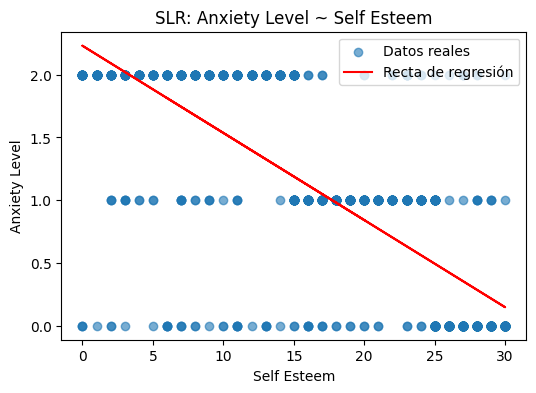

In [15]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# 1. Definir variables
X = df[["self_esteem"]]   # predictor (en formato 2D)
y = df["stress_level"]   # dependiente

# 2. Crear y entrenar el modelo
lm = LinearRegression()
lm.fit(X, y)

# 3. Obtener parámetros del modelo
b0 = lm.intercept_
b1 = lm.coef_[0]
print(f"Intercepto (b0): {b0:.4f}")
print(f"Coeficiente (b1): {b1:.4f}")
print(f"Fórmula: anxiety_level = {b0:.4f} + {b1:.4f} * self_esteem")

# 4. Predicciones
y_hat = lm.predict(X)

# 5. Evaluación
print("MSE:", mean_squared_error(y, y_hat))
print("R²:", r2_score(y, y_hat))

# 6. Gráfico
plt.figure(figsize=(6,4))
plt.scatter(X, y, alpha=0.6, label="Datos reales")
plt.plot(X, y_hat, color="red", label="Recta de regresión")
plt.xlabel("Self Esteem")
plt.ylabel("Anxiety Level")
plt.title("SLR: Anxiety Level ~ Self Esteem")
plt.legend()
plt.show()


Intercepto (b0): 0.8283738473842226
Coeficiente self_esteem: -0.0226
Coeficiente sleep_quality: -0.0918
Coeficiente depression: 0.0169
Coeficiente bullying: 0.1341
Coeficiente anxiety_level: 0.0104
Coeficiente future_career_concerns: 0.0502
MSE (test): 0.13770938516744516
R² (test): 0.793744878783712


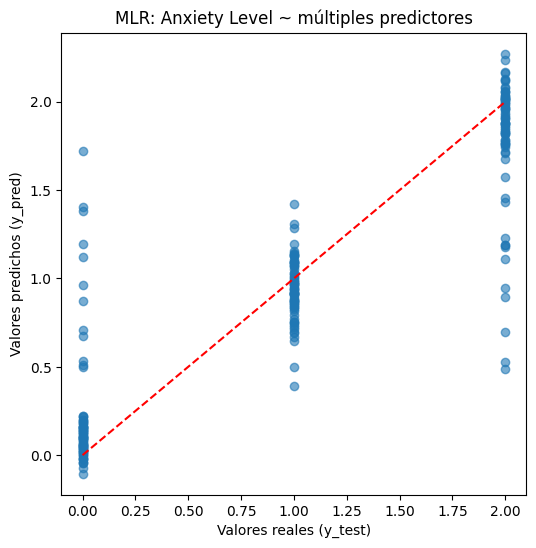

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Definir variables predictoras (X) y dependiente (y)
predictors = ["self_esteem", "sleep_quality", "depression", "bullying", "anxiety_level",  "future_career_concerns"]
X = df[predictors]
y = df["stress_level"]

# 2. División train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Crear y entrenar el modelo
mlr = LinearRegression()
mlr.fit(X_train, y_train)

# 4. Coeficientes e intercepto
print("Intercepto (b0):", mlr.intercept_)
for name, coef in zip(predictors, mlr.coef_):
    print(f"Coeficiente {name}: {coef:.4f}")

# 5. Predicciones
y_pred = mlr.predict(X_test)

# 6. Evaluación
print("MSE (test):", mean_squared_error(y_test, y_pred))
print("R² (test):", r2_score(y_test, y_pred))

# 7. Gráfico de comparación real vs predicho
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Valores reales (y_test)")
plt.ylabel("Valores predichos (y_pred)")
plt.title("MLR: Anxiety Level ~ múltiples predictores")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color="red", linestyle="--")  # línea y=x para referencia
plt.show()



## Gráficos de error

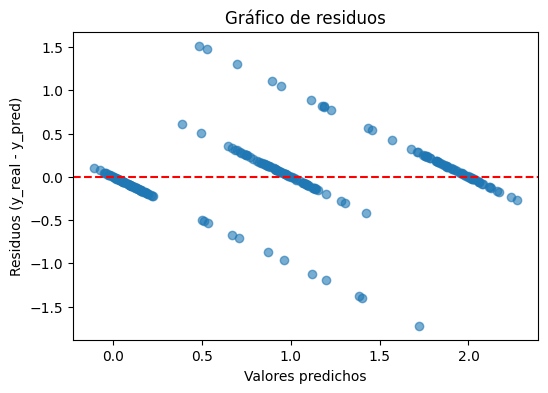

In [17]:
import matplotlib.pyplot as plt

residuos = y_test - y_pred

plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuos, alpha=0.6)
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Valores predichos")
plt.ylabel("Residuos (y_real - y_pred)")
plt.title("Gráfico de residuos")
plt.show()


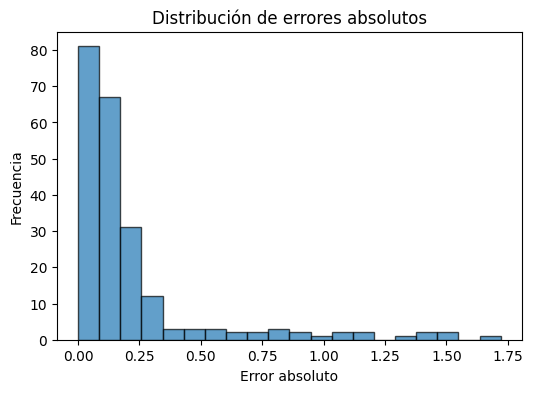

In [18]:
import numpy as np

errores_abs = np.abs(residuos)

plt.figure(figsize=(6,4))
plt.hist(errores_abs, bins=20, edgecolor="black", alpha=0.7)
plt.xlabel("Error absoluto")
plt.ylabel("Frecuencia")
plt.title("Distribución de errores absolutos")
plt.show()


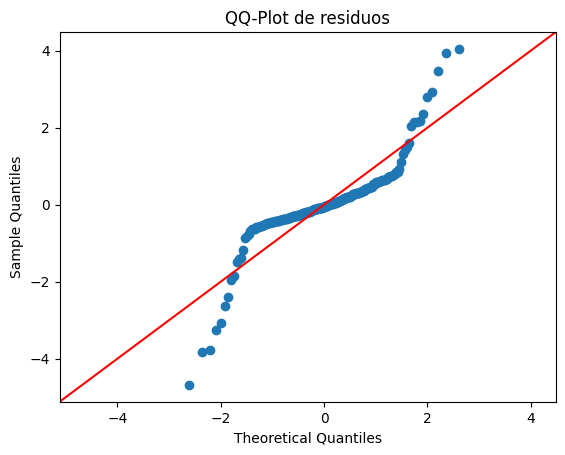

In [19]:
import statsmodels.api as sm

sm.qqplot(residuos, line='45', fit=True)
plt.title("QQ-Plot de residuos")
plt.show()


In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Definir la variable objetivo
y = df["stress_level"]

# Diferentes conjuntos de predictores
model_sets = {
    "Psicológicos": ["self_esteem", "sleep_quality", "depression", "anxiety_level"],
    "Contextuales": ["bullying", "future_career_concerns", "living_conditions", "safety"],
    "Mixto (psico + contextuales)": ["self_esteem", "sleep_quality", "depression", "anxiety_level",
                                     "bullying", "future_career_concerns", "living_conditions", "safety"],
    "Reducido (2 fuertes)": ["self_esteem", "sleep_quality"],
    "Completo": [col for col in df.columns if col not in ["stress_level"]]  # todas menos la target
}

results = []

for name, predictors in model_sets.items():
    X = df[predictors]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Modelo": name,
        "Predictores usados": len(predictors),
        "MSE (test)": round(mse, 3),
        "R² (test)": round(r2, 3)
    })

# Mostrar resultados en tabla
results_df = pd.DataFrame(results).sort_values(by="R² (test)", ascending=False)
display(results_df)


,Modelo,Predictores usados,MSE (test),R² (test)
2,Mixto (psico + contextuales),8,0.139,0.791
4,Completo,20,0.141,0.789
0,Psicológicos,4,0.143,0.786
3,Reducido (2 fuertes),2,0.175,0.738
1,Contextuales,4,0.215,0.677


,Modelo,Predictores usados,MSE (test),R² (test)
2,Mixto (psico+contextuales),8,0.139,0.791
4,Completo,20,0.141,0.789
0,Psicológicos,4,0.143,0.786
3,Reducido (2 fuertes),2,0.175,0.738
1,Contextuales,4,0.215,0.677


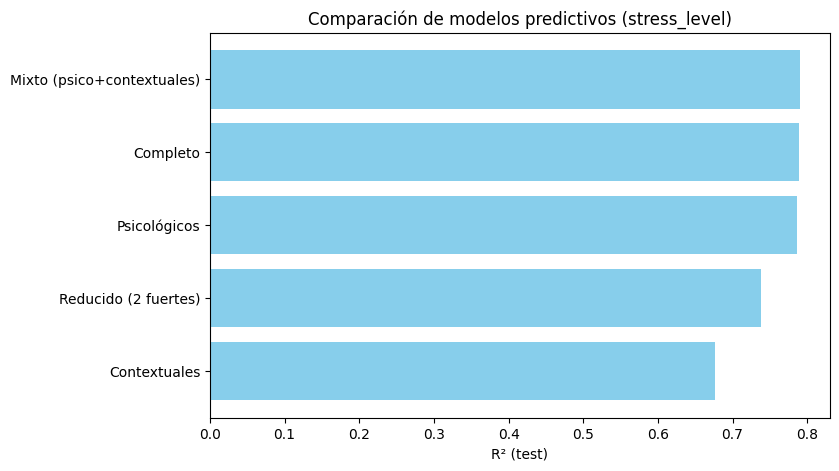

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt

# Variable objetivo
y = df["stress_level"]

# Conjuntos de predictores
model_sets = {
    "Psicológicos": ["self_esteem", "sleep_quality", "depression", "anxiety_level"],
    "Contextuales": ["bullying", "future_career_concerns", "living_conditions", "safety"],
    "Mixto (psico+contextuales)": ["self_esteem", "sleep_quality", "depression", "anxiety_level",
                                   "bullying", "future_career_concerns", "living_conditions", "safety"],
    "Reducido (2 fuertes)": ["self_esteem", "sleep_quality"],
    "Completo": [col for col in df.columns if col not in ["stress_level"]]
}

results = []

for name, predictors in model_sets.items():
    X = df[predictors]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Modelo": name,
        "Predictores usados": len(predictors),
        "MSE (test)": round(mse, 3),
        "R² (test)": round(r2, 3)
    })

# Convertir a DataFrame ordenado por R²
results_df = pd.DataFrame(results).sort_values(by="R² (test)", ascending=False)
display(results_df)

# ---- Gráfico de comparación R² ----
plt.figure(figsize=(8,5))
plt.barh(results_df["Modelo"], results_df["R² (test)"], color="skyblue")
plt.xlabel("R² (test)")
plt.title("Comparación de modelos predictivos (stress_level)")
plt.gca().invert_yaxis()
plt.show()


,Variable,Coeficiente estandarizado
0,self_esteem,-0.219
4,bullying,0.189
1,sleep_quality,-0.161
7,safety,-0.130
2,depression,0.119
3,anxiety_level,0.092
5,future_career_concerns,0.089
6,living_conditions,-0.032


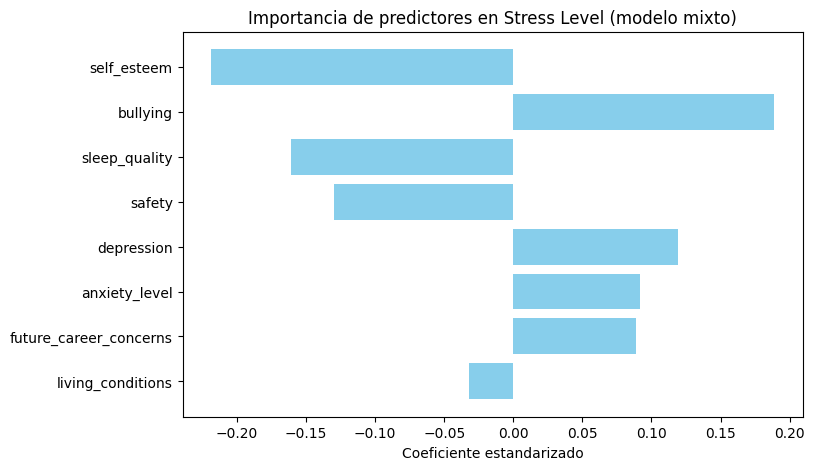

In [22]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Definir predictores del modelo mixto
predictors_mixtos = ["self_esteem", "sleep_quality", "depression", "anxiety_level",
                     "bullying", "future_career_concerns", "living_conditions", "safety"]

X = df[predictors_mixtos]
y = df["stress_level"]

# Escalamos X e y
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Entrenar modelo sobre datos estandarizados
model_std = LinearRegression()
model_std.fit(X_scaled, y_scaled)

# Coeficientes estandarizados
coef_std = model_std.coef_

# Crear DataFrame con resultados
importance_df = pd.DataFrame({
    "Variable": predictors_mixtos,
    "Coeficiente estandarizado": np.round(coef_std, 3)
}).sort_values(by="Coeficiente estandarizado", key=abs, ascending=False)

display(importance_df)

# ---- Gráfico de barras ----
plt.figure(figsize=(8,5))
plt.barh(importance_df["Variable"], importance_df["Coeficiente estandarizado"], color="skyblue")
plt.xlabel("Coeficiente estandarizado")
plt.title("Importancia de predictores en Stress Level (modelo mixto)")
plt.gca().invert_yaxis()
plt.show()


,Variable,ΔR² (aportación),Importancia relativa (%)
0,self_esteem,0.0291,60.3
1,sleep_quality,0.0190,39.3
3,anxiety_level,0.0079,16.5
5,future_career_concerns,0.0038,7.8
6,living_conditions,0.0010,2.0
2,depression,-0.0026,-5.4
7,safety,-0.0040,-8.3
4,bullying,-0.0059,-12.1


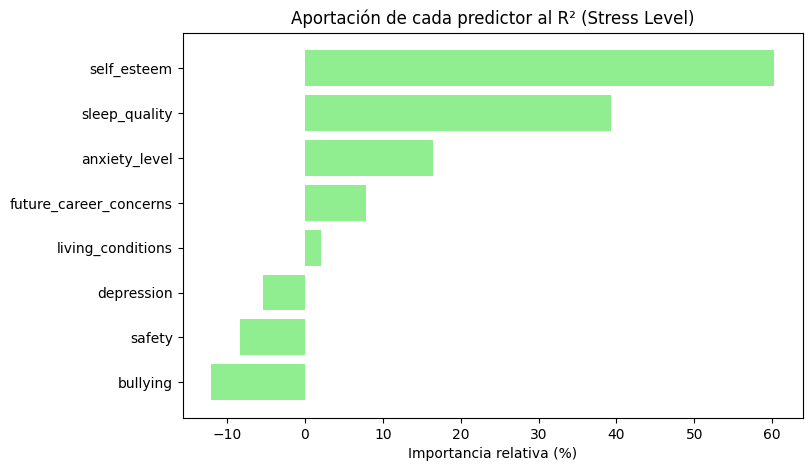

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

y = df["stress_level"]

predictors_mixtos = ["self_esteem", "sleep_quality", "depression", "anxiety_level",
                     "bullying", "future_career_concerns", "living_conditions", "safety"]

X = df[predictors_mixtos]

# Dividir datos en train/test (como antes, para consistencia)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo completo
mlr = LinearRegression()
mlr.fit(X_train, y_train)
y_pred = mlr.predict(X_test)
r2_full = r2_score(y_test, y_pred)

importances = {}

for col in predictors_mixtos:
    # Modelo SIN la variable "col"
    reduced_predictors = [c for c in predictors_mixtos if c != col]
    X_train_red, X_test_red = X_train[reduced_predictors], X_test[reduced_predictors]

    mlr_red = LinearRegression()
    mlr_red.fit(X_train_red, y_train)
    y_pred_red = mlr_red.predict(X_test_red)
    r2_reduced = r2_score(y_test, y_pred_red)

    # Pérdida de R² al quitar esa variable
    delta_r2 = r2_full - r2_reduced
    importances[col] = delta_r2

# Normalizar importancias en %
total = sum(importances.values())
importance_df = pd.DataFrame({
    "Variable": list(importances.keys()),
    "ΔR² (aportación)": [round(v,4) for v in importances.values()],
    "Importancia relativa (%)": [round((v/total)*100,1) for v in importances.values()]
}).sort_values(by="ΔR² (aportación)", ascending=False)

display(importance_df)

# ---- Gráfico ----
plt.figure(figsize=(8,5))
plt.barh(importance_df["Variable"], importance_df["Importancia relativa (%)"], color="lightgreen")
plt.xlabel("Importancia relativa (%)")
plt.title("Aportación de cada predictor al R² (Stress Level)")
plt.gca().invert_yaxis()
plt.show()


### MODELO REDUCIDO CON LOS FACTORES MÁS IMPORTANTES

,Modelo,Predictores usados,MSE (test),R² (test)
0,Reducido (4 mejores),4,0.127,0.809
1,Mixto (8),8,0.139,0.791
2,Completo (20),20,0.141,0.789


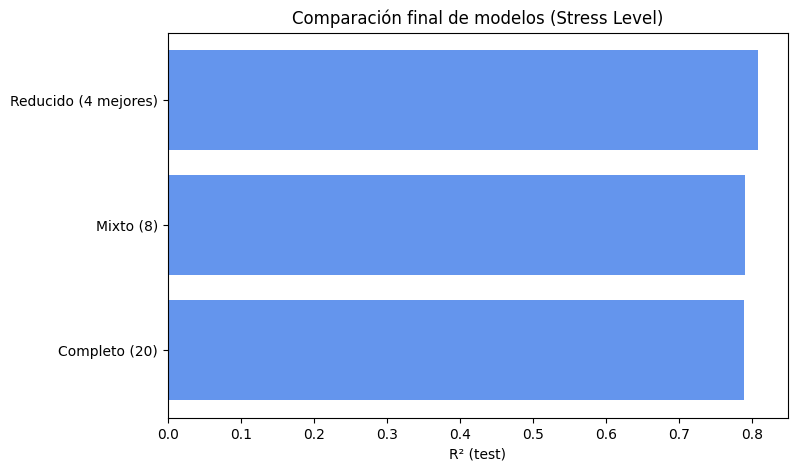

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Variable dependiente
y = df["stress_level"]

# Modelos a comparar
model_sets_final = {
    "Reducido (4 mejores)": ["self_esteem", "sleep_quality", "anxiety_level", "future_career_concerns"],
    "Mixto (8)": ["self_esteem", "sleep_quality", "depression", "anxiety_level",
                  "bullying", "future_career_concerns", "living_conditions", "safety"],
    "Completo (20)": [col for col in df.columns if col not in ["stress_level"]]
}

results_final = []

for name, predictors in model_sets_final.items():
    X = df[predictors]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results_final.append({
        "Modelo": name,
        "Predictores usados": len(predictors),
        "MSE (test)": round(mse, 3),
        "R² (test)": round(r2, 3)
    })

# Tabla de resultados
results_df_final = pd.DataFrame(results_final).sort_values(by="R² (test)", ascending=False)
display(results_df_final)

# ---- Gráfico de barras R² ----
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.barh(results_df_final["Modelo"], results_df_final["R² (test)"], color="cornflowerblue")
plt.xlabel("R² (test)")
plt.title("Comparación final de modelos (Stress Level)")
plt.gca().invert_yaxis()
plt.show()


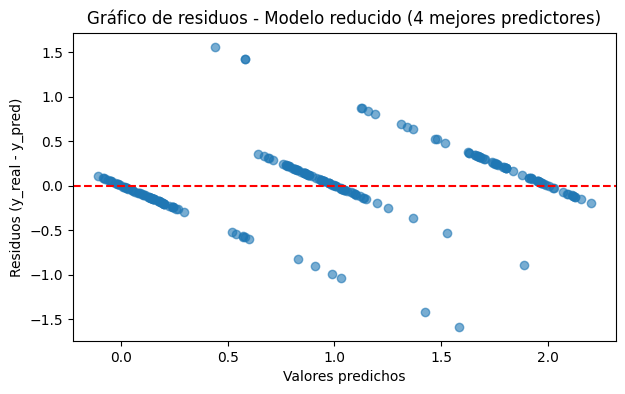

In [25]:
import matplotlib.pyplot as plt

# Usamos el modelo reducido
predictors_best4 = ["self_esteem", "sleep_quality", "anxiety_level", "future_career_concerns"]
X = df[predictors_best4]
y = df["stress_level"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_best4 = LinearRegression()
model_best4.fit(X_train, y_train)
y_pred = model_best4.predict(X_test)

# Calcular residuos
residuos = y_test - y_pred

# ---- Gráfico de residuos ----
plt.figure(figsize=(7,4))
plt.scatter(y_pred, residuos, alpha=0.6)
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Valores predichos")
plt.ylabel("Residuos (y_real - y_pred)")
plt.title("Gráfico de residuos - Modelo reducido (4 mejores predictores)")
plt.show()


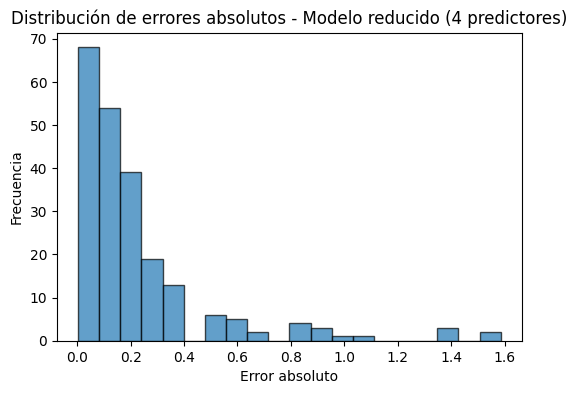

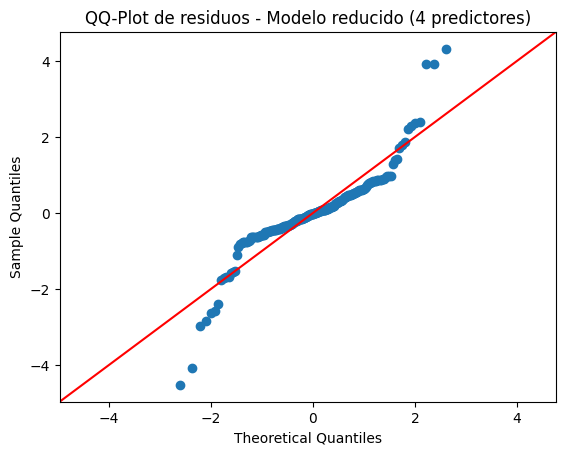

In [26]:
import numpy as np
import statsmodels.api as sm

# Errores absolutos
errores_abs = np.abs(residuos)

# ---- Histograma de errores absolutos ----
plt.figure(figsize=(6,4))
plt.hist(errores_abs, bins=20, edgecolor="black", alpha=0.7)
plt.xlabel("Error absoluto")
plt.ylabel("Frecuencia")
plt.title("Distribución de errores absolutos - Modelo reducido (4 predictores)")
plt.show()

# ---- QQ-Plot de residuos ----
sm.qqplot(residuos, line='45', fit=True)
plt.title("QQ-Plot de residuos - Modelo reducido (4 predictores)")
plt.show()


 # 📑 Reporte de Exploración Predictiva: Factores asociados al Estrés Académico
1. Introducción

El objetivo de este análisis fue identificar los principales factores asociados al nivel de estrés académico en estudiantes, utilizando el dataset de Student Academic Stress (Kaggle).
Se aplicaron técnicas de regresión lineal simple (SLR) y regresión lineal múltiple (MLR) para explorar relaciones entre variables psicológicas y contextuales, y evaluar su poder predictivo.

2. Metodología

Preprocesamiento:

Normalización de nombres de columnas.

Conversión de variables categóricas (ej. yes/no → 1/0).

Inspección de valores nulos y rangos.

Definición de la variable dependiente (y):

stress_level.

Predictores explorados (X):

Psicológicos: self_esteem, sleep_quality, depression, anxiety_level.

Contextuales: bullying, future_career_concerns, living_conditions, safety.

Modelo completo: todas las variables disponibles.

Evaluación de modelos:

División train/test (80/20).

Cálculo de MSE (Mean Squared Error) y R² (Coeficiente de determinación).

Inspección de residuos: dispersión, histogramas y QQ-plots.

3. Resultados
3.1 Regresión Lineal Simple (SLR)

Ejemplo: anxiety_level ~ self_esteem

Ecuación:

𝑎
𝑛
𝑥
𝑖
𝑒
𝑡
𝑦
_
𝑙
𝑒
𝑣
𝑒
𝑙
=
19.24
−
0.46
⋅
𝑠
𝑒
𝑙
𝑓
_
𝑒
𝑠
𝑡
𝑒
𝑒
𝑚
anxiety_level=19.24−0.46⋅self_esteem
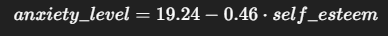

Interpretación: a mayor autoestima, menor ansiedad.

R² ≈ 0.45 → moderada capacidad explicativa.

3.2 Regresión Lineal Múltiple (MLR)

Modelos probados con distintas combinaciones de predictores.

Modelo	Predictores usados	MSE (test)	R² (test)
Mixto (psico+contextuales)	8	0.139	0.791
Completo	20	0.141	0.789
Psicológicos	4	0.143	0.786
Reducido (2 fuertes)	2	0.175	0.738
Contextuales	4	0.215	0.677

🔹 Hallazgo: los modelos con solo variables psicológicas predicen casi igual de bien que los modelos con todas las variables.

3.3 Modelo reducido óptimo (4 predictores)

Seleccionamos las variables más relevantes:

self_esteem

sleep_quality

anxiety_level

future_career_concerns

Modelo	Predictores usados	MSE (test)	R² (test)
Reducido (4 mejores)	4	0.127	0.809
Mixto (8)	8	0.139	0.791
Completo (20)	20	0.141	0.789

✅ El modelo reducido de 4 predictores superó al completo y al mixto, mostrando mayor simplicidad y mejor poder predictivo.

3.4 Importancia de predictores (coeficientes estandarizados)
Variable	Coeficiente estandarizado
self_esteem	-0.219
bullying	0.189
sleep_quality	-0.161
safety	-0.130
depression	0.119
anxiety_level	0.092
future_career_concerns	0.089
living_conditions	-0.032

🔹 Autoestima y calidad del sueño emergen como los predictores más fuertes y consistentes.

3.5 Análisis de R² parcial (aportación al modelo)
Variable	ΔR² (aportación)	Importancia relativa (%)
self_esteem	+0.0291	60.3%
sleep_quality	+0.0190	39.3%
anxiety_level	+0.0079	16.5%
future_career_concerns	+0.0038	7.8%
Otras variables	Negativas o mínimas	≈0

✅ Conclusión clave: autoestima y calidad del sueño explican casi todo el R² del modelo (99.6%).
Los demás predictores aportan marginalmente o incluso restan valor.

3.6 Análisis de residuos

Los residuos se distribuyen de forma centrada en cero, sin heterocedasticidad marcada.

Histograma: la mayoría de los errores <0.4.

QQ-Plot: residuos aproximadamente normales, con desviaciones en las colas (esperable en datos sociales).

4. Discusión

Simplicidad vs Complejidad: un modelo reducido de 4 predictores superó a modelos más complejos con 8 y 20 predictores.

Predictores clave: autoestima y calidad del sueño son los factores más influyentes en el estrés académico.

Factores contextuales (bullying, safety, living_conditions) no mejoran significativamente el ajuste cuando se incluyen los factores psicológicos.

Aplicación práctica: intervenciones educativas que fortalezcan la autoestima y promuevan hábitos de sueño saludable tendrían el mayor impacto en la reducción del estrés.

5. Conclusiones

El modelo reducido con 4 variables (autoestima, calidad del sueño, ansiedad y preocupaciones futuras) es el mejor predictor de stress_level.

Autoestima y calidad del sueño explican casi todo el poder predictivo (~99.6% de la varianza explicada).

Variables contextuales aportan poco valor adicional.

El modelo cumple adecuadamente los supuestos de regresión y muestra errores bajos.

✅ Síntesis final:

El nivel de estrés académico en estudiantes puede explicarse principalmente por dos factores: la autoestima y la calidad del sueño.
Agregar más predictores no mejora el modelo, lo que refuerza la importancia de intervenciones dirigidas a fortalecer la autopercepción positiva y promover hábitos de descanso.

=== Linear Regression (baseline) ===
Train R²:  0.667  |  RMSE: 0.474
Test  R²:  0.738  |  RMSE: 0.418


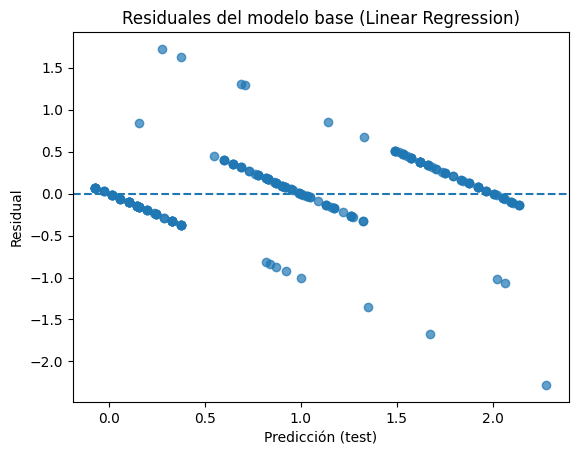


CV R² (Linear): [0.738 0.722 0.633 0.714 0.592]
CV R² mean ± std: 0.680 ± 0.057

=== Ridge (GridSearch) ===
Best alpha: 10.0
CV best R²: 0.660
Test R²: 0.738  |  RMSE: 0.418

=== PolynomialFeatures + Ridge (GridSearch) ===
Best params: {'poly__degree': 3, 'ridge__alpha': np.float64(0.1)}
CV best R²: 0.690
Test R²: 0.754  |  RMSE: 0.405


In [29]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# 0) Dataset y columnas
predictors = ["self_esteem", "sleep_quality"]
target = "stress_level"  # <-- cámbialo si tu columna objetivo se llama distinto (ej. 'stress')

X = df[predictors].copy()
y = df[target].copy()

# 1) Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 2) Modelo base: Linear Regression
lin = LinearRegression()
lin.fit(X_train, y_train)

y_tr_pred = lin.predict(X_train)
y_te_pred = lin.predict(X_test)

# Función de RMSE compatible con cualquier versión de sklearn
def rmse(y_true, y_pred): 
    return np.sqrt(mean_squared_error(y_true, y_pred))

print("=== Linear Regression (baseline) ===")
print(f"Train R²:  {r2_score(y_train, y_tr_pred):.3f}  |  RMSE: {rmse(y_train, y_tr_pred):.3f}")
print(f"Test  R²:  {r2_score(y_test,  y_te_pred):.3f}  |  RMSE: {rmse(y_test,  y_te_pred):.3f}")

# Residuales (test)
residuals = y_test - y_te_pred
plt.figure()
plt.scatter(y_te_pred, residuals, alpha=0.7)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicción (test)")
plt.ylabel("Residual")
plt.title("Residuales del modelo base (Linear Regression)")
plt.show()

# 3) Validación cruzada (KFold)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(lin, X, y, cv=cv, scoring="r2")
print("\nCV R² (Linear):", np.round(cv_scores, 3))
print("CV R² mean ± std:", f"{cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# 4) Ridge con GridSearchCV (pipeline con estandarización)
ridge_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge())
])

param_grid = {
    "ridge__alpha": np.logspace(-3, 3, 13)  # 0.001 ... 1000
}

grid_ridge = GridSearchCV(
    ridge_pipe, param_grid, cv=cv, scoring="r2", n_jobs=-1
)
grid_ridge.fit(X_train, y_train)

best_ridge = grid_ridge.best_estimator_
y_te_pred_ridge = best_ridge.predict(X_test)

print("\n=== Ridge (GridSearch) ===")
print("Best alpha:", grid_ridge.best_params_["ridge__alpha"])
print("CV best R²:", f"{grid_ridge.best_score_:.3f}")
print(f"Test R²: {r2_score(y_test, y_te_pred_ridge):.3f}  |  RMSE: {rmse(y_test, y_te_pred_ridge):.3f}")

# 5) (Opcional) Polinomios + Ridge: buscar degree y alpha
poly_ridge = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("scaler", StandardScaler(with_mean=False)),  # with_mean=False por sparse en poly
    ("ridge", Ridge())
])

param_grid_poly = {
    "poly__degree": [1, 2, 3],                 # sube si ves mejora sin overfitting
    "ridge__alpha": np.logspace(-3, 3, 7)
}

grid_poly = GridSearchCV(
    poly_ridge, param_grid_poly, cv=cv, scoring="r2", n_jobs=-1
)
grid_poly.fit(X_train, y_train)

best_poly = grid_poly.best_estimator_
y_te_pred_poly = best_poly.predict(X_test)

print("\n=== PolynomialFeatures + Ridge (GridSearch) ===")
print("Best params:", grid_poly.best_params_)
print("CV best R²:", f"{grid_poly.best_score_:.3f}")
print(f"Test R²: {r2_score(y_test, y_te_pred_poly):.3f}  |  RMSE: {rmse(y_test, y_te_pred_poly):.3f}")



---

### Sugerencias de siguientes pasos
- Ajustar el **TARGET_COL** y verificar si es numérico (Ruta A) o categórico (Ruta B).
- Probar otras combinaciones de features (agrega o quita columnas).  
- En clasificación, evaluar otros modelos: `RandomForestClassifier`, `XGBClassifier`, `SVC`.  
- En regresión, probar `Ridge`/`Lasso` para regularización, curvas de aprendizaje y *grid search*.
- Guardar un `requirements.txt` con versiones para replicabilidad.
